# Monte Carlo Fund Strategy Simulator

<a href="https://colab.research.google.com/github/raedventures/MonteCarloFundSimulator/blob/main/notebooks/fund_simulator.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


This notebook aims to help fund managers evaluate different fund deployment strategies and look at the risks and rewards associated with each approach

# Initial Setup
Start by importing repo from github

In [3]:
import os, sys

user = "raedventures"
repo = "MonteCarloFundSimulator"
src_dir = "src"
nb_dir = "notebooks"
strat_dir = "strategy"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}"
if not path in sys.path:
    sys.path.insert(1, f"{repo}")
    sys.path.insert(1, f"{repo}/{src_dir}")
    sys.path.insert(1, f"{repo}/{nb_dir}")
    sys.path.insert(1, f"{repo}/{src_dir}/{strat_dir}")

print("repo clone completed")
# list all directories in the Python path
# print("\n".join(["'" + path + "'" for path in sys.path]))

Cloning into 'MonteCarloFundSimulator'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 63 (delta 20), reused 51 (delta 14), pack-reused 0
Unpacking objects: 100% (63/63), done.
repo clone completed


# Run Simulation

Monte Carlo Fund Simulation # 10000 / 10000: |██████████████████████████████████████████████████| 100.00% 



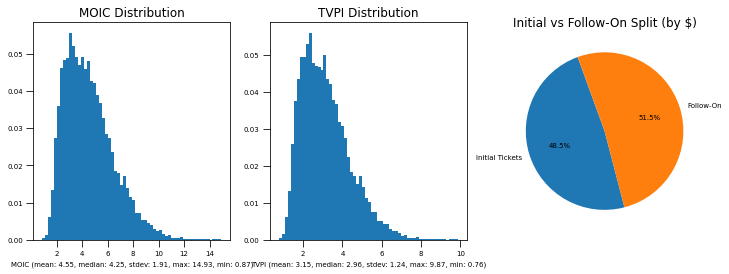

In [5]:
from simulator_engine import runSimulation, plotStats
from simple_prorata_strategy import SimpleProRataStrategy
from plot_stats import plot_stats_notebook

moics, tvpis, outcomes, [it, ft] = runSimulation(SimpleProRataStrategy(), 10000)

# plot fund performance summary
plot_stats_notebook(moics, tvpis, outcomes, [it, ft])